In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import load_model
import tensorflow as tf

In [ ]:
model = load_model("/content/drive/My Drive/Driver Distraction/driver.hdf5")

# Model to TFLite

In [ ]:
TFLITE_MODEL = "driver.tflite"

In [ ]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

8882308

# Load TFLite model

In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 4]
type: <class 'numpy.float32'>


# Load Test Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from keras.preprocessing import image

In [ ]:
p_test = Path("/content/drive/My Drive/Driver Distraction/test")

dirsr = p_test.glob("*")

test_image_data = []
test_label_data = []
sum_test = 0
for folder_path in dirsr :
    label = (str(folder_path)).split("/")[-1]
    
    cnt = 0
    print("Processing ",label)
    
    for img_path in folder_path.glob("*"):
        img = image.load_img(img_path,target_size=(224,224))
        img_array = image.img_to_array(img)
        
        test_image_data.append(img_array)
        test_label_data.append(label)
        
        cnt += 1
        
    print("Number of images: ",cnt)
    sum_test +=cnt
    
print("Total Number of images: ",sum_test)

Processing  Yawning
Number of images:  14
Processing  Head Drop
Number of images:  10
Processing  Safe
Number of images:  18
Processing  Swing
Number of images:  20
Total Number of images:  62


In [ ]:
label_dict = {}

cnt = 0
for labels in np.unique(test_label_data):
    label_dict[labels] = cnt
    cnt +=1
    
label_dict.items()

dict_items([('Head Drop', 0), ('Safe', 1), ('Swing', 2), ('Yawning', 3)])

In [ ]:
for i in range(len(test_label_data)):
    test_label_data[i] = label_dict[test_label_data[i]]

In [ ]:
reverse_dict = dict((value,key) for (key,value) in label_dict.items())
reverse_dict.items()

dict_items([(0, 'Head Drop'), (1, 'Safe'), (2, 'Swing'), (3, 'Yawning')])

In [ ]:
Xtest = np.array(test_image_data)/255.0
Ytest = np.array(test_label_data).astype('float32')

print(Xtest.shape)
print(Ytest.shape)

(62, 224, 224, 3)
(62,)


# Visualize Test Data

In [ ]:
def drawImg(img,label):
    plt.style.use("seaborn")
    plt.title(reverse_dict[label])
    plt.axis("off")
    plt.imshow(img)
    plt.show()

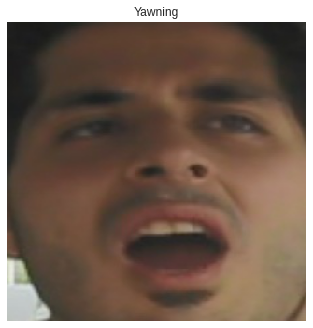

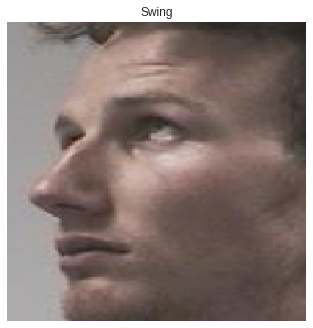

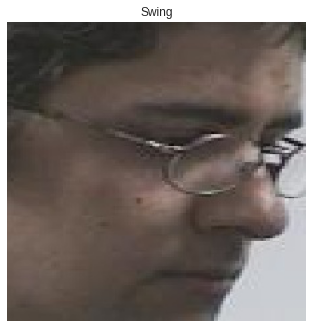

In [ ]:
for i in range(3):
    r = np.random.randint(len(Xtest))
    drawImg(Xtest[r],Ytest[r])

# Change Batch-Size of TFLite Model

In [ ]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (sum_test, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (sum_test, 3))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [ 62 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [62  4]
type: <class 'numpy.float32'>


# Get Predictions

In [ ]:
tflite_interpreter.set_tensor(input_details[0]['index'], Xtest)

In [ ]:
tflite_interpreter.invoke()

In [ ]:
tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (62, 4)


In [ ]:
import pandas as pd

In [ ]:
tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = label_dict.keys()

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()

TFLite prediction results for the first elements


,Head Drop,Safe,Swing,Yawning
0,0.003377,0.194840,0.004033,0.797750
1,0.013952,0.848498,0.025292,0.112258
2,0.001299,0.120202,0.001501,0.876998
3,0.001658,0.226163,0.002323,0.769856
4,0.005012,0.043586,0.012381,0.939021


# Precision-Recall

In [ ]:
result = np.zeros((tflite_model_predictions.shape[0]))
for i in range(tflite_model_predictions.shape[0]):
        result[i] = np.argmax(tflite_model_predictions[i])

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(result,Ytest))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      0.90      0.95        20
         2.0       1.00      1.00      1.00        20
         3.0       0.86      1.00      0.92        12

    accuracy                           0.97        62
   macro avg       0.96      0.97      0.97        62
weighted avg       0.97      0.97      0.97        62



# Confusion-Matrix

In [ ]:
cnf_matrix = confusion_matrix(result,Ytest)
print(cnf_matrix)

[[10  0  0  0]
 [ 0 18  0  2]
 [ 0  0 20  0]
 [ 0  0  0 12]]
